In [2]:
import pyift.pyift as ift
import matplotlib.pyplot as plt

### Read an image img, create Sobel X- and Y-Kernels, and show the original image

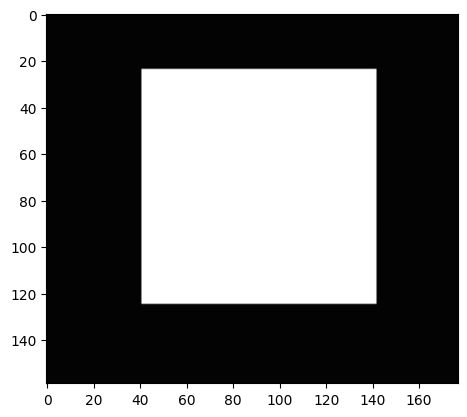

In [6]:
img = ift.ReadImageByExt("images/square.png")
Kx  = ift.SobelXKernel2D()
Ky  = ift.SobelYKernel2D()
plt.imshow(img.ToPlot())

### Convolutions between an image and the Sobel X- and Y-Kernels (Linear Filters) are derivatives along the X and Y directions. Hence, transitions from darker to brighter pixels are positives and from brighter to darker pixels are negatives. We can visualize both transitions by linear stretching (a point-wise operation) the images into a positive intensity range.   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


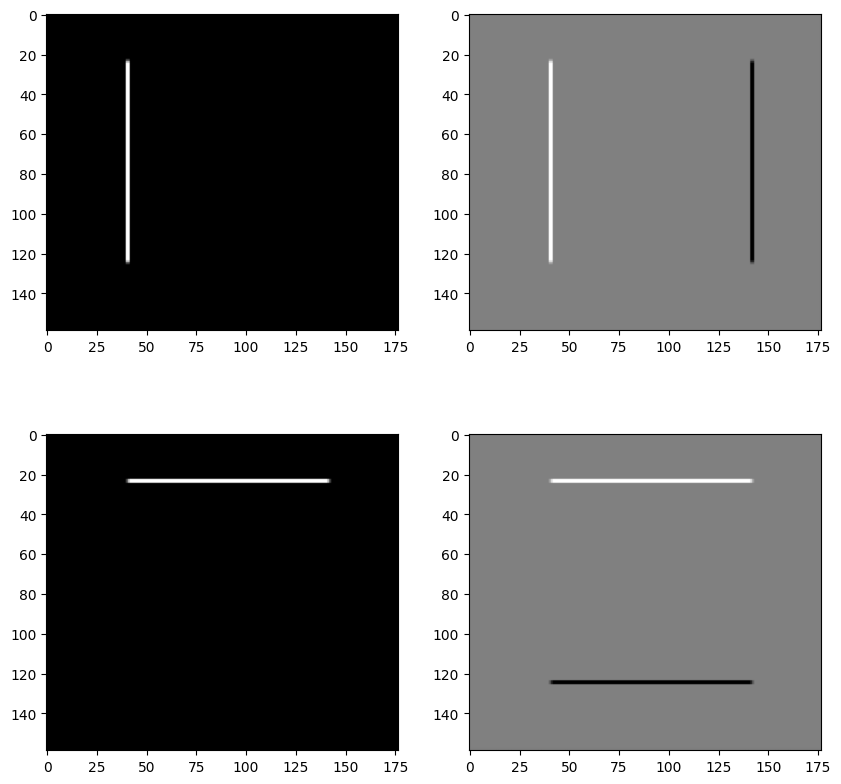

In [3]:
Dx  = ift.LinearFilter(img, Kx)
PDx = ift.LinearStretch(Dx,ift.MinimumValue(Dx),ift.MaximumValue(Dx),0,255) 
Dy  = ift.LinearFilter(img, Ky)
PDy = ift.LinearStretch(Dy,ift.MinimumValue(Dy),ift.MaximumValue(Dy),0,255)

fig, axes = plt.subplots(2, 2, figsize=(10,10))
images = [Dx, PDx, Dy, PDy]
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].ToPlot())
plt.show()

#### The Sobel gradient $$ \vec{G} = (Dx)\vec{i} + (Dy)\vec{j} $$ Then one can compute the gradient magnitude $$ G = (Dx)^2 + (Dy)^2 $$ 

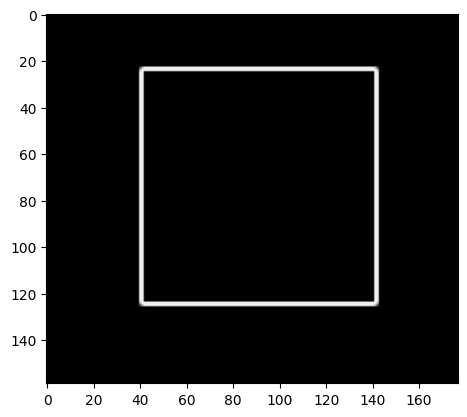

In [4]:
G = ift.SobelGradientMagnitude(img)
plt.imshow(G.ToPlot())

### Such linear filters can be used to extract image features. For instance, one can enhance vertical edges in a license plate detection problem.

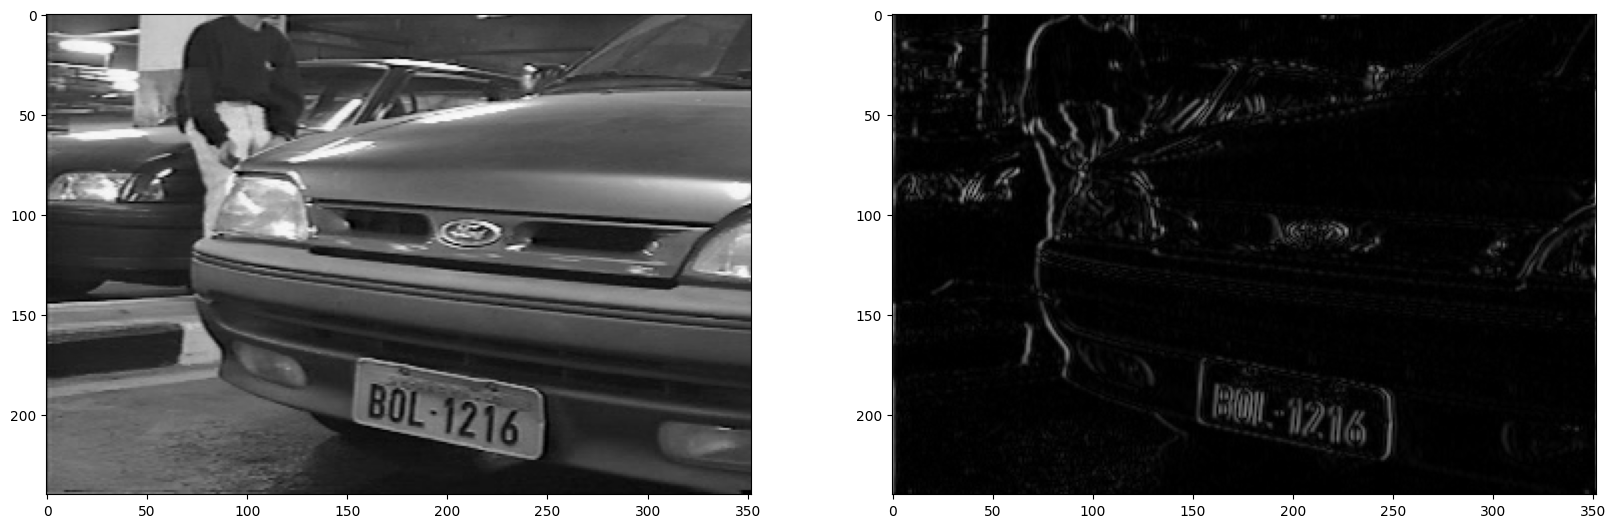

In [5]:
img = ift.ReadImageByExt("images/plate.png")
vrt_edges  = ift.Abs(ift.LinearFilter(img, Kx))
fig, axes = plt.subplots(1, 2, figsize=(20,10))
images = [img, vrt_edges]
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].ToPlot())
plt.show()


### Since the vertical edges in the plate are near each other, one can estimate the cummulative values inside rectangular regions centered at pixels p. The highest cummulative values should identify pixels inside the plate. The integral image (we will learn about it later) can speed up the process as shown next. 

In [6]:
integ  = ift.IntegralImage(vrt_edges)
# the regions with sizes 107 x 15 are placed at each pixel (i.e., the displacement is (0,0)) 
cumm   = ift.CumValueInRegion(integ,0,0,0,107,15,0)
maxval = ift.FMaximumValue(cumm)
bin    = ift.FThreshold(cumm,0.9*maxval,maxval,255)

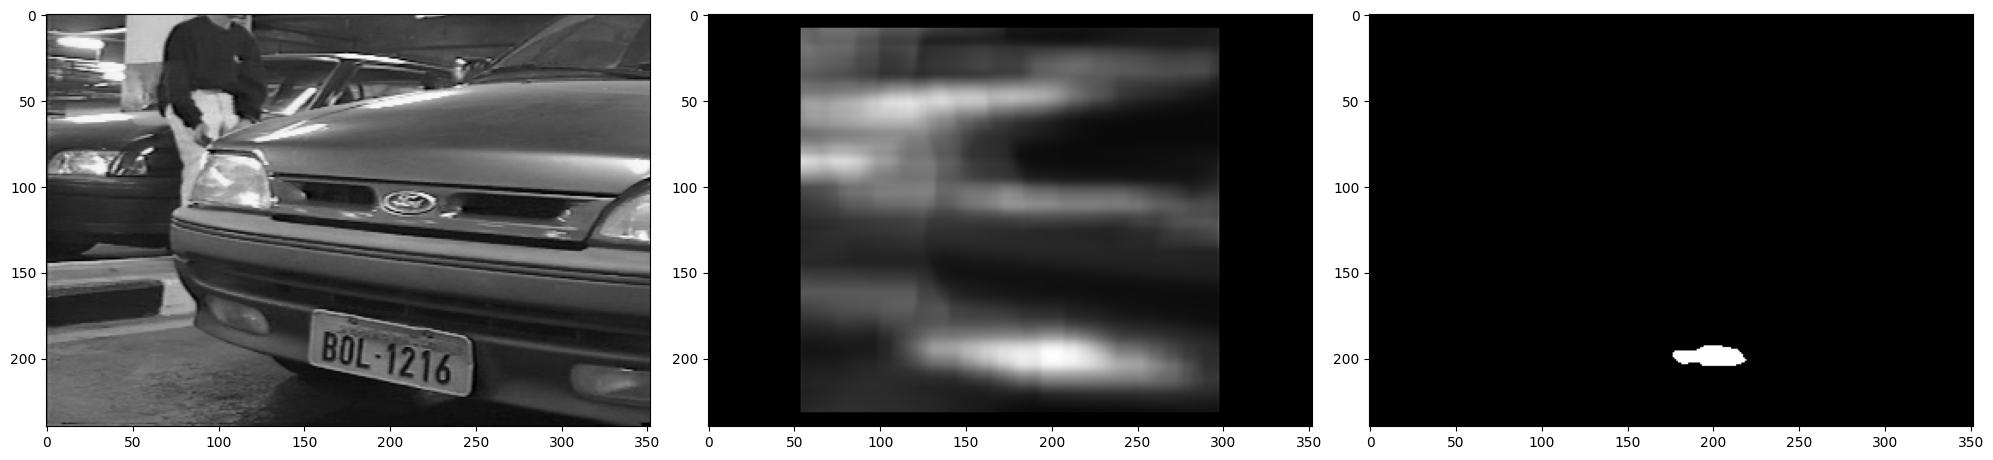

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20,10))
fig.tight_layout()
images = [img, cumm, bin]
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].ToPlot())
plt.show()

### Kernel banks may be created with random kernels, Gabor filters, learned from image markers, learned by backpropagation, etc. Random kernels whose weights have mean 0.0 may be applied to extract random features from a given image. Let's see an example with a microscopy image containing an egg of the parasite Schistosoma Mansoni.    

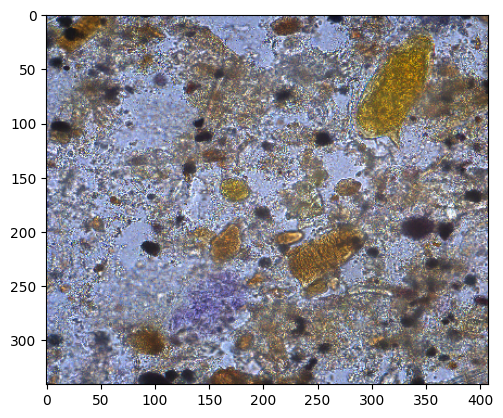

In [8]:
img = ift.ReadImageByExt("images/smansoni.png")
plt.imshow(img.ToPlot())

### We will see that the operation of an artificial neuron corresponds to a convolution followed by an activation. In the case of a kernel bank, such multiple neurons are important elements for feature extraction in convolutional neural networks (CNNs).  

In [9]:
A           = ift.Circular(3.0)
nbands      = 3
nkernels    = 16
# create a random kernel bank 
kernel_bank = ift.RandomMMKernel(A, nbands, nkernels)
# convert the image into a multi-band image in the Lab normalized color space
mimg        = ift.ImageToMImage(img, color_space=ift.LABNorm2_CSPACE)
# compute convolution between the image and the kernel bank
feats       = ift.MMLinearFilter(mimg, kernel_bank)
# apply Rectified Linear Unit (ReLU) activation.  
feats       = ift.MReLU(feats,None,False)

### Even with random kernels, foreground and background activations may be observed. We will see how to estimate them from image markers, when designing CNNs for object detection

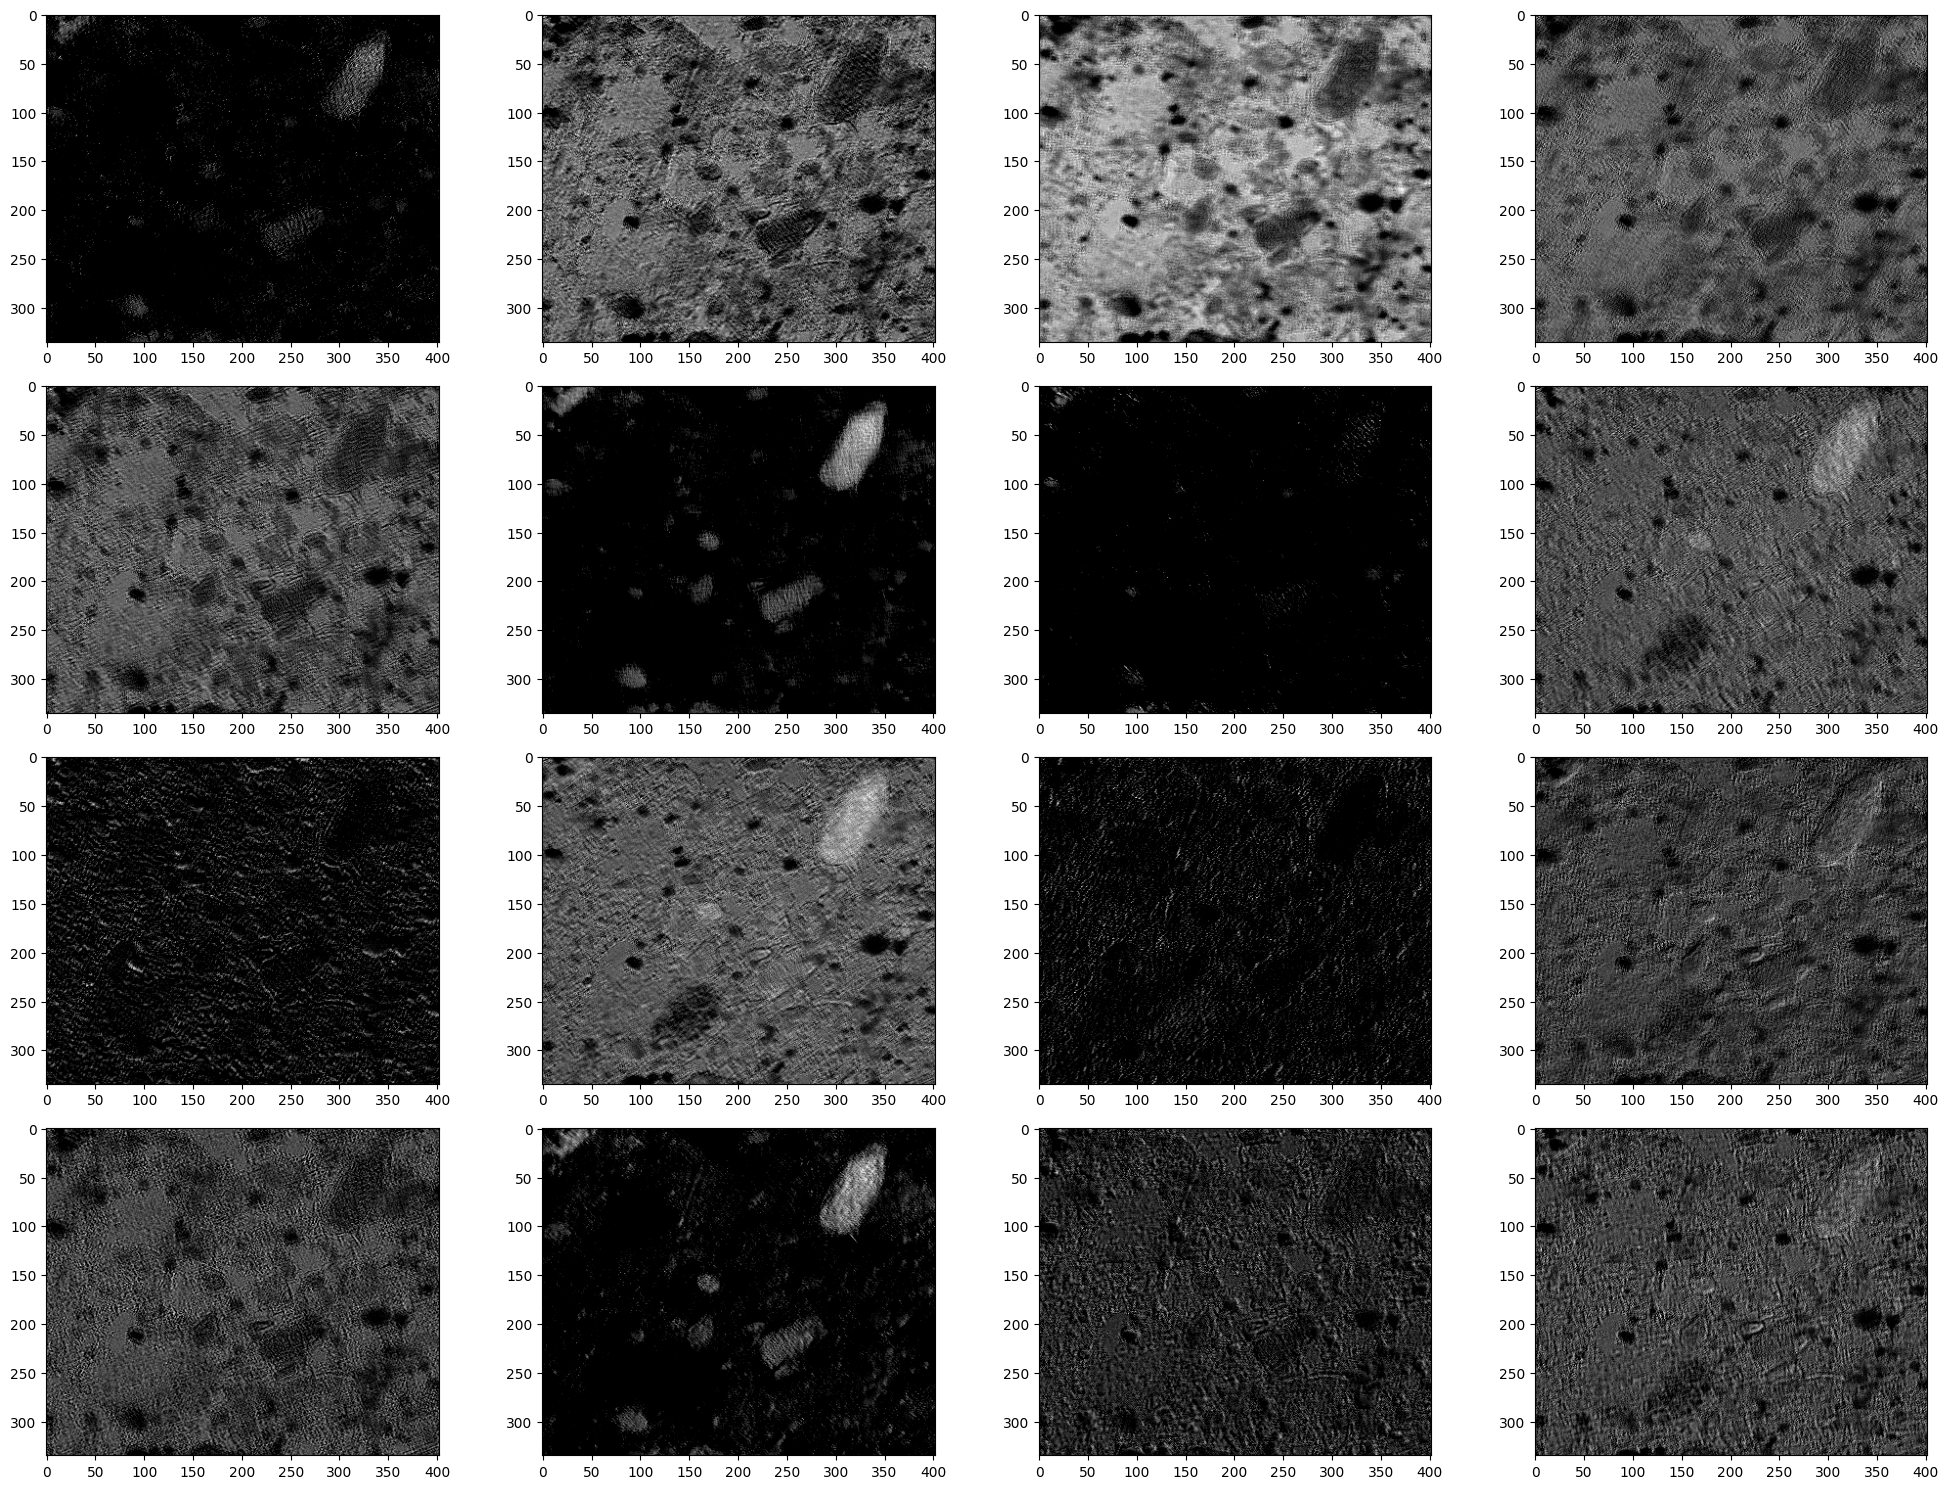

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(20,15))
fig.tight_layout()
images = []
for b in range(0,nkernels):
    images.append(ift.MImageToImage(feats,255,b))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].ToPlot())
plt.show()